# MTF Entry/Exit v1 Lab

Visualize the new multi-timeframe confluence strategy.

What this notebook shows:
- Price, Daily EMA(50), and ATR trailing stop
- Executed buys and sells (colored by exit reason)
- Equity curve and drawdown
- Confluence score, cooldown, and equity-kill events


[ok] APO -> out/mtf_entry_exit_v1/APO.csv (782 rows)
[ok] TSLA -> out/mtf_entry_exit_v1/TSLA.csv (782 rows)

Summary
  symbols: 2
  success: 2
  failed:  0
  out dir: out/mtf_entry_exit_v1
  latest file:  out/mtf_entry_exit_v1_latest.csv
  summary file: out/mtf_entry_exit_v1_summary.csv
  errors file:  out/mtf_entry_exit_v1_errors.csv

Strategy Event Summary
symbol: APO
rows: 782
entry setups: 9
executed buys: 5
executed sells: 5
sell reasons: {'EQUITY_KILL': 5}
ending equity: 91748.63
max drawdown %: 10.06


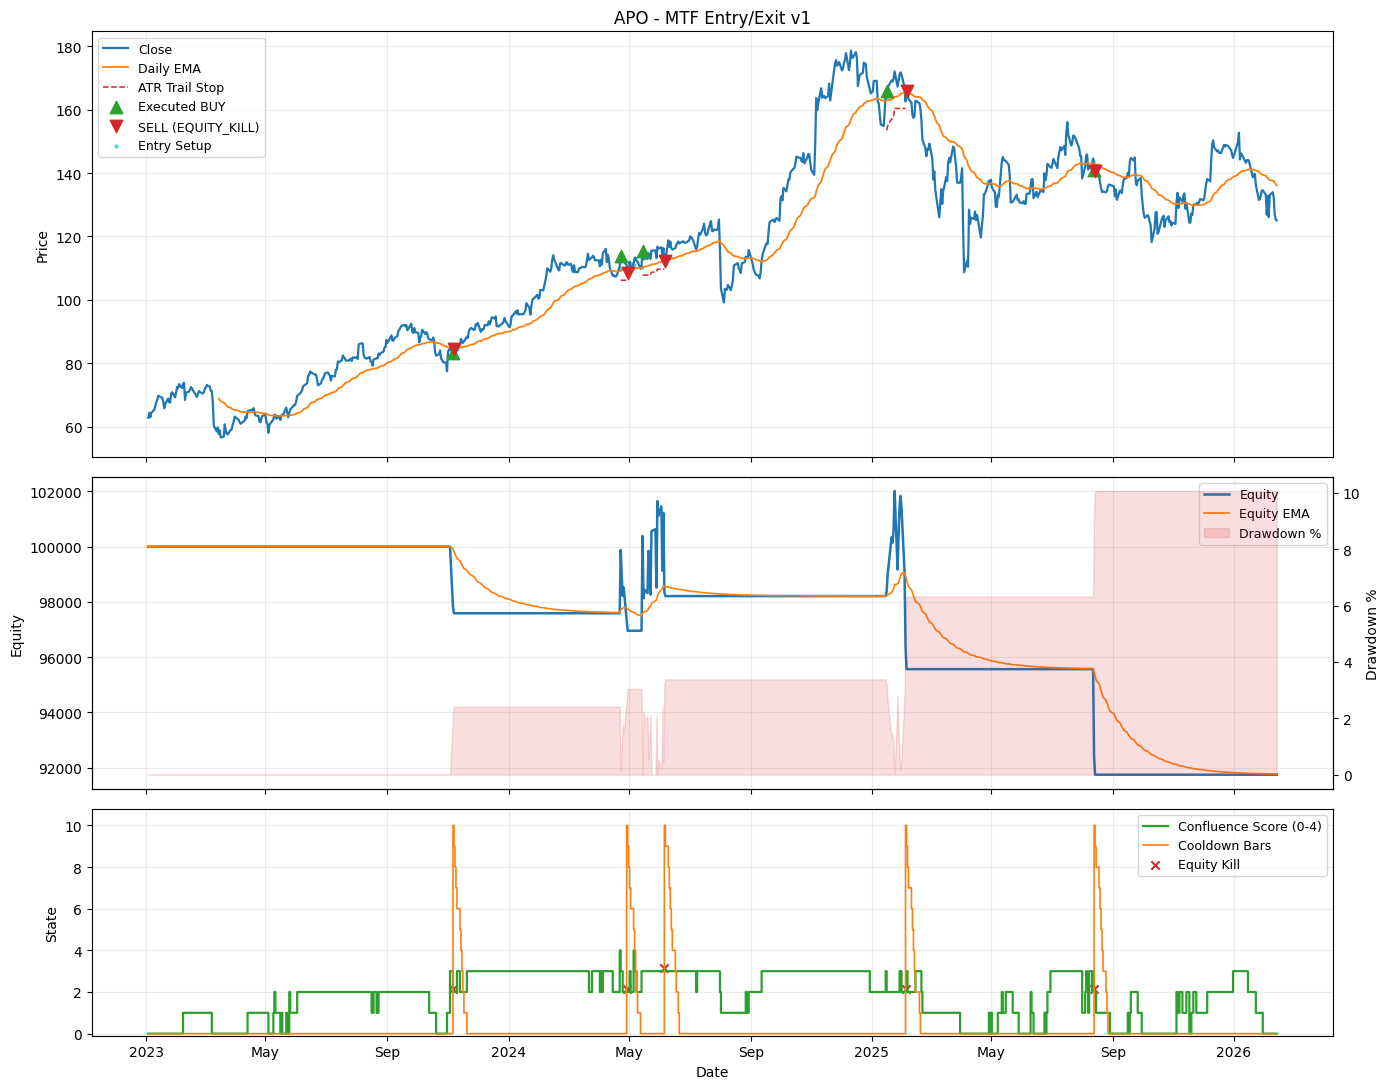

In [1]:
from __future__ import annotations

from collections import Counter
from datetime import date
from pathlib import Path
import csv
import math
import subprocess
import sys

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

SYMBOL = "APO"
RUN_STRATEGY = True
DATE_FROM = None  # example: date.fromisoformat("2024-01-01")
DATE_TO = None    # example: date.fromisoformat("2026-12-31")


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / "mtf_entry_exit_v1.py").exists() and (candidate / "out").exists():
            return candidate
    raise FileNotFoundError("Could not locate repository root")


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


def parse_int(value: str | None) -> int:
    raw = (value or "").strip()
    if not raw:
        return 0
    return int(float(raw))


def parse_flag(value: str | None) -> int:
    return 1 if (value or "").strip() == "1" else 0


repo_root = resolve_repo_root()
out_dir = repo_root / "out"

if RUN_STRATEGY:
    cmd = [sys.executable, str(repo_root / "mtf_entry_exit_v1.py")]
    proc = subprocess.run(cmd, cwd=repo_root, capture_output=True, text=True)
    if proc.returncode != 0:
        print(proc.stdout)
        print(proc.stderr)
        raise RuntimeError("mtf_entry_exit_v1.py failed")
    print(proc.stdout)

csv_path = out_dir / "mtf_entry_exit_v1" / f"{SYMBOL}.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"Missing strategy output: {csv_path}")

rows: list[dict[str, str]] = []
with csv_path.open("r", encoding="utf-8", newline="") as handle:
    reader = csv.DictReader(handle)
    for row in reader:
        row_date = date.fromisoformat(row["Date"])
        if DATE_FROM is not None and row_date < DATE_FROM:
            continue
        if DATE_TO is not None and row_date > DATE_TO:
            continue
        rows.append(row)

if not rows:
    raise ValueError("No rows after date filtering")

dates = [date.fromisoformat(row["Date"]) for row in rows]
close = [parse_float(row.get("Close")) for row in rows]
daily_ema = [parse_float(row.get("DailyEMA")) for row in rows]
atr_trail_stop = [parse_float(row.get("ATRTrailStop")) for row in rows]
equity = [parse_float(row.get("Equity")) for row in rows]
equity_ema = [parse_float(row.get("EquityEMA")) for row in rows]
drawdown_pct = [parse_float(row.get("DrawdownPct")) for row in rows]
cooldown = [parse_int(row.get("CooldownRemaining")) for row in rows]

monthly_up = [parse_flag(row.get("MonthlyUp")) for row in rows]
weekly_up = [parse_flag(row.get("WeeklyUp")) for row in rows]
daily_cross = [parse_flag(row.get("DailyCrossAboveEMA")) for row in rows]
momentum_pos = [parse_flag(row.get("MomentumPositive")) for row in rows]
equity_kill = [parse_flag(row.get("EquityKill")) for row in rows]
entry_setup = [parse_flag(row.get("EntrySetup")) for row in rows]
confluence_score = [monthly_up[idx] + weekly_up[idx] + daily_cross[idx] + momentum_pos[idx] for idx in range(len(rows))]

buy_idx = [idx for idx, row in enumerate(rows) if (row.get("ExecutedAction") or "").strip() == "BUY"]
sell_idx = [idx for idx, row in enumerate(rows) if (row.get("ExecutedAction") or "").strip() == "SELL"]

sell_reason_to_indices: dict[str, list[int]] = {}
for idx in sell_idx:
    reason = (rows[idx].get("ExecutedReason") or "UNKNOWN").strip() or "UNKNOWN"
    sell_reason_to_indices.setdefault(reason, []).append(idx)

reason_counts = Counter((rows[idx].get("ExecutedReason") or "UNKNOWN").strip() or "UNKNOWN" for idx in sell_idx)

entry_setup_count = sum(entry_setup)
buy_count = len(buy_idx)
sell_count = len(sell_idx)
last_equity = equity[-1] if equity[-1] is not None else float("nan")
max_drawdown = max(v for v in drawdown_pct if v is not None)

print("Strategy Event Summary")
print(f"symbol: {SYMBOL}")
print(f"rows: {len(rows)}")
print(f"entry setups: {entry_setup_count}")
print(f"executed buys: {buy_count}")
print(f"executed sells: {sell_count}")
print(f"sell reasons: {dict(reason_counts)}")
print(f"ending equity: {last_equity:.2f}")
print(f"max drawdown %: {max_drawdown:.2f}")


def values_or_nan(values: list[float | None]) -> list[float]:
    return [v if v is not None else math.nan for v in values]


fig, (ax_price, ax_equity, ax_state) = plt.subplots(
    3,
    1,
    figsize=(14, 11),
    sharex=True,
    gridspec_kw={"height_ratios": [3.0, 2.2, 1.6]},
)

ax_price.plot(dates, values_or_nan(close), label="Close", color="#1f77b4", linewidth=1.6)
ax_price.plot(dates, values_or_nan(daily_ema), label="Daily EMA", color="#ff7f0e", linewidth=1.3)
ax_price.plot(dates, values_or_nan(atr_trail_stop), label="ATR Trail Stop", color="#d62728", linewidth=1.1, linestyle="--")

if buy_idx:
    ax_price.scatter(
        [dates[idx] for idx in buy_idx],
        [close[idx] for idx in buy_idx],
        marker="^",
        s=80,
        color="#2ca02c",
        label="Executed BUY",
        zorder=5,
    )

sell_colors = {
    "EQUITY_KILL": "#d62728",
    "ATR_TRAIL": "#9467bd",
    "EMA50_FAIL": "#8c564b",
}
for reason, indices in sell_reason_to_indices.items():
    ax_price.scatter(
        [dates[idx] for idx in indices],
        [close[idx] for idx in indices],
        marker="v",
        s=80,
        color=sell_colors.get(reason, "#7f7f7f"),
        label=f"SELL ({reason})",
        zorder=5,
    )

setup_idx = [idx for idx, flag in enumerate(entry_setup) if flag == 1]
if setup_idx:
    ax_price.scatter(
        [dates[idx] for idx in setup_idx],
        [close[idx] * 0.995 for idx in setup_idx],
        marker=".",
        s=18,
        color="#17becf",
        alpha=0.6,
        label="Entry Setup",
    )

ax_price.set_title(f"{SYMBOL} - MTF Entry/Exit v1")
ax_price.set_ylabel("Price")
ax_price.grid(alpha=0.25)
ax_price.legend(loc="best", fontsize=9)

ax_equity.plot(dates, values_or_nan(equity), label="Equity", color="#1f77b4", linewidth=1.8)
ax_equity.plot(dates, values_or_nan(equity_ema), label="Equity EMA", color="#ff7f0e", linewidth=1.2)
ax_equity.set_ylabel("Equity")
ax_equity.grid(alpha=0.25)

ax_dd = ax_equity.twinx()
ax_dd.fill_between(dates, [0.0] * len(dates), values_or_nan(drawdown_pct), color="#d62728", alpha=0.15, label="Drawdown %")
ax_dd.set_ylabel("Drawdown %")

line1, label1 = ax_equity.get_legend_handles_labels()
line2, label2 = ax_dd.get_legend_handles_labels()
ax_equity.legend(line1 + line2, label1 + label2, loc="best", fontsize=9)

ax_state.step(dates, confluence_score, where="post", label="Confluence Score (0-4)", color="#2ca02c", linewidth=1.6)
ax_state.step(dates, cooldown, where="post", label="Cooldown Bars", color="#ff7f0e", linewidth=1.2)

kill_idx = [idx for idx, flag in enumerate(equity_kill) if flag == 1]
if kill_idx:
    ax_state.scatter(
        [dates[idx] for idx in kill_idx],
        [confluence_score[idx] + 0.15 for idx in kill_idx],
        marker="x",
        s=35,
        color="#d62728",
        label="Equity Kill",
    )

ax_state.set_ylabel("State")
ax_state.set_ylim(-0.1, max(4.6, max(cooldown) + 0.8))
ax_state.grid(alpha=0.25)
ax_state.legend(loc="best", fontsize=9)

ax_state.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_state.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax_state.xaxis.get_major_locator()))
ax_state.set_xlabel("Date")

plt.tight_layout()
plt.show()
